In [46]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

cuda is available!


In [3]:

num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = './autoencoder'

In [4]:

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [21]:

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0,1] => [-1,1]ほんとかな？ちょっとはみ出す気もするが。
])
train_dataset = MNIST('../data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [22]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
if cuda:
    model.cuda()




In [23]:

def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [32]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

loss_list = []


In [42]:

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_list.append(loss)
    
    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss))

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))
        pic2 = to_img(x.cpu().data)
        save_image(pic2, './{}/image_original_{}.png'.format(out_dir, epoch))

np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

epoch [1/100], loss: 0.1578
epoch [2/100], loss: 0.1553
epoch [3/100], loss: 0.1392
epoch [4/100], loss: 0.1578
epoch [5/100], loss: 0.1439
epoch [6/100], loss: 0.1475
epoch [7/100], loss: 0.1497
epoch [8/100], loss: 0.1544
epoch [9/100], loss: 0.1472
epoch [10/100], loss: 0.1546
epoch [11/100], loss: 0.1523
epoch [12/100], loss: 0.1498
epoch [13/100], loss: 0.1724
epoch [14/100], loss: 0.1583
epoch [15/100], loss: 0.1524
epoch [16/100], loss: 0.1497
epoch [17/100], loss: 0.1553
epoch [18/100], loss: 0.1634
epoch [19/100], loss: 0.1488
epoch [20/100], loss: 0.1378
epoch [21/100], loss: 0.1603
epoch [22/100], loss: 0.1620
epoch [23/100], loss: 0.1414
epoch [24/100], loss: 0.1530
epoch [25/100], loss: 0.1482
epoch [26/100], loss: 0.1438
epoch [27/100], loss: 0.1398
epoch [28/100], loss: 0.1480
epoch [29/100], loss: 0.1543
epoch [30/100], loss: 0.1586
epoch [31/100], loss: 0.1581
epoch [32/100], loss: 0.1420
epoch [33/100], loss: 0.1545
epoch [34/100], loss: 0.1606
epoch [35/100], loss: 0

In [44]:
loss_list = np.load('{}/loss_list.npy'.format(out_dir),allow_pickle=True)

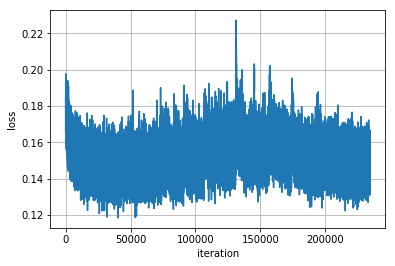

In [47]:

plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()

In [49]:
from IPython.display import Image
Image('autoencoder/image_0.png')


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [50]:


model.load_state_dict(torch.load('{}/autoencoder.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [51]:
test_dataset = MNIST('../data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)


In [52]:
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

In [59]:

# 784次元ベクトルを2次元ベクトルにencode
z = model.encoder(Variable(images, volatile=True).cuda())

/home/user/PycharmProjects/auto_encoder/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:

z=z.data

In [61]:
print(z)


tensor([[-116.7354,  -40.2552],
        [   6.5734,  -28.7348],
        [  -9.6908,   -1.9379],
        ...,
        [ -16.8657,   -7.9893],
        [  -2.8960,    3.4786],
        [   1.9530,   -6.8526]], device='cuda:0')


In [63]:
print(z.size())

torch.Size([10000, 2])


In [65]:
z = z.cpu()

In [66]:
print(z)

tensor([[-116.7354,  -40.2552],
        [   6.5734,  -28.7348],
        [  -9.6908,   -1.9379],
        ...,
        [ -16.8657,   -7.9893],
        [  -2.8960,    3.4786],
        [   1.9530,   -6.8526]])


In [67]:
print(z.size())

torch.Size([10000, 2])


In [68]:
z = z.numpy()

In [69]:
print(z)

[[-116.73542    -40.255184 ]
 [   6.5733933  -28.734848 ]
 [  -9.690819    -1.9379398]
 ...
 [ -16.865746    -7.9893007]
 [  -2.8960013    3.4786081]
 [   1.953023    -6.852561 ]]


In [72]:
print(z.shape)

(10000, 2)


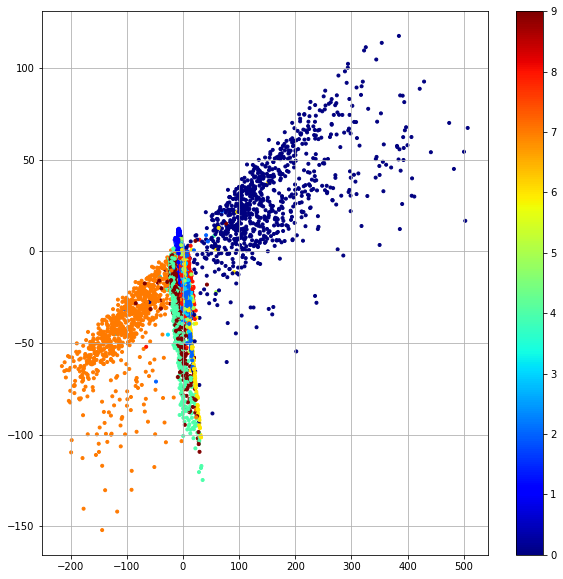

In [73]:

import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()